In [1]:
# Импорт библиотек
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
import xgboost as xgb

In [3]:
# Загрузка и подготовка данных
# Online Retail Dataset
df = pd.read_excel('data1/Online Retail.xlsx', sheet_name='Online Retail')

# Просмотр первых строк данных
print(df.head())

  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  


In [4]:
# Очистка данных
df.dropna(subset=['CustomerID'], inplace=True)  # Удаление строк без CustomerID
df = df[df['Quantity'] > 0]  # Удаление отрицательных значений Quantity

# Преобразование данных
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['Month'] = df['InvoiceDate'].dt.to_period('M')

# Пример агрегации данных
monthly_sales = df.groupby(['Month', 'CustomerID'])['Quantity'].sum().reset_index()

In [5]:
# Модель для прогнозирования поведения
X = monthly_sales[['Quantity']].values
y = (monthly_sales['Quantity'] > monthly_sales['Quantity'].median()).astype(int)  # Простая бинарная классификация

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
# XGBoost модель
xgb_model = xgb.XGBClassifier(use_label_encoder=False)

In [8]:
# Параметры для GridSearch
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1, 0.2]
}

In [10]:
# GridSearch для подбора гиперпараметров
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)


Fitting 3 folds for each of 27 candidates, totalling 81 fits


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [02:16:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [02:16:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [02:16:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [02:16:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 6, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy', verbose=1)

In [11]:
# Лучшие параметры и модель
print(f'Лучшие параметры: {grid_search.best_params_}')
best_model = grid_search.best_estimator_

Лучшие параметры: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50}


In [12]:
# Оценка модели
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1278
           1       1.00      1.00      1.00      1333

    accuracy                           1.00      2611
   macro avg       1.00      1.00      1.00      2611
weighted avg       1.00      1.00      1.00      2611

[[1278    0]
 [   0 1333]]


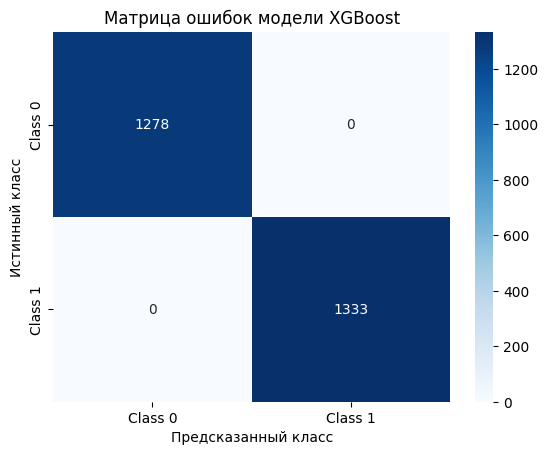

In [13]:
# Визуализация результатов
# Матрица ошибок
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title('Матрица ошибок модели XGBoost')
plt.xlabel('Предсказанный класс')
plt.ylabel('Истинный класс')
plt.show()


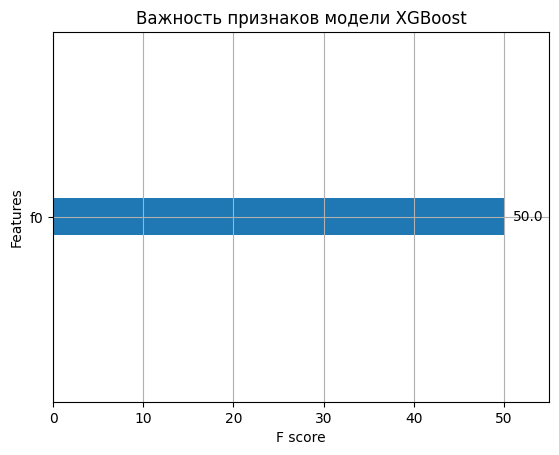

In [14]:
# Дополнительные графики (например, важность признаков)
xgb.plot_importance(best_model)
plt.title('Важность признаков модели XGBoost')
plt.show()%

In [ ]:
# Важность признаков модели XGBoost
import matplotlib.pyplot as plt
from xgboost import plot_importance

plot_importance(xgb_final_model)
plt.show()